In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
LEARNING_RATE = .001

In [4]:
training_generator = ImageDataGenerator(rescale=1./255, rotation_range=25, width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.1)
test_generator = ImageDataGenerator(rescale=1./255)

train_it = training_generator.flow_from_directory('Covid19-dataset/train/', target_size=(256,256), color_mode="grayscale", class_mode="categorical", batch_size=BATCH_SIZE)

test_it = test_generator.flow_from_directory('Covid19-dataset/test/', target_size=(256,256), color_mode="grayscale", class_mode="categorical", batch_size=BATCH_SIZE)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [5]:
def BuildModel(l_rate):
    model = Sequential()
    # Input
    model.add(keras.Input(shape=(256,256,1)))
    # Hidden Layers
    model.add(layers.Conv2D(5, 5, activation='relu', strides=3))
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Dropout(0.1))
    # Hidden Layers
    model.add(layers.Conv2D(4, 3, activation='relu', strides=1))
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Dropout(0.2))
    # Flatten
    model.add(layers.Flatten())
    # Output
    model.add(layers.Dense(3, activation='softmax'))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=l_rate), 
        loss=keras.losses.CategoricalCrossentropy(), 
        metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.AUC()]
    )

    return model

In [6]:
model = BuildModel(LEARNING_RATE)
stop = EarlyStopping(monitor='val_auc', mode='min', patience=20, verbose=1)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 84, 84, 5)         130       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 5)         0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 4)         184       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

Epoch 00021: early stopping


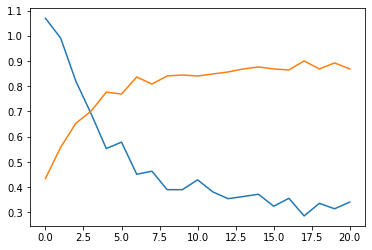

In [7]:
history = model.fit(
    train_it,
        steps_per_epoch=train_it.samples/BATCH_SIZE, 
        epochs=20,
        validation_data=test_it,
        validation_steps=test_it.samples/BATCH_SIZE,
        callbacks=[stop],
        verbose=0
)

plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['categorical_accuracy'])
plt.ylabel='loss/accuracy'
plt.xlabel='epochs'
plt.show()

In [25]:
test_steps_per_epoch = np.math.ceil(test_it.samples / test_it.batch_size)
labels = model.predict(test_it, steps=test_steps_per_epoch)
labels = np.argmax(labels, axis=-1)

true = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true, labels, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       Covid       0.25      0.23      0.24        26
      Normal       0.32      0.30      0.31        20
   Pneumonia       0.26      0.30      0.28        20

    accuracy                           0.27        66
   macro avg       0.28      0.28      0.28        66
weighted avg       0.27      0.27      0.27        66

